Prepare dataset

In [1]:
import cv2
import os

import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
alphabets=list("0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
num_alphabet = len(alphabets)
NUM_OF_LETTERS=5


PATH = "/home/datascience/Desktop/Capt"
DATA_PATH = os.path.join(PATH, 'train')
DATA_PATH
BATCH_SIZE = 16
EPOCHS = 150
IMG_ROW, IMG_COLS = 50, 201

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set hyperparameters
NUM_CLASSES = 5
LR = 0.0001
SMOOTHING = 0.1


In [2]:
def load_data(path, capp,test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            # print(len(f),f)
            if '.png' in fl:
                flr = fl.split('_')[0]
                # print(flr,"aaaaafsfsssf")
                # print(fl,type(fl),"aaaaafsfsssf")
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                f2=capp.loc[capp["ID"]==flr.strip()]["labels"]#["labels"]
                # print(capp.loc[capp["ID"]==fl.strip()]["labels"][0],"11111111111111!!")
                # print(f2,type(f2),"aaaaaaaaaaaa")
                f2=f2[int(flr.split(".")[0])]
                # print(f2,"asfafsafs")
                for i in range(NUM_OF_LETTERS):
                    label[i, alphabets.index(f2[i])] = 1
                    # print(label.shape,label)
#                 label = np.zeros((50, 1))
#                 for i in range(5):
#                     label[i*5+int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(201/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random.random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
     

In [ ]:
capp=pd.read_excel("/home/datascience/Downloads/cAPTCHA.xlsx",sheet_name="Sheet3",usecols=["ID","labels"]) 
#### You can read txt file too or convert them to excel and read that

In [5]:

x_train, y_train, x_test, y_test = load_data(DATA_PATH,capp)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train=np.transpose(x_train, axes=( 0,3, 1, 2))
x_test=np.transpose(x_test, axes=( 0, 3, 1, 2))
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 1000 (train=884, test=116)


In [87]:

y_train[np.where(y_train == 1)] = 1-SMOOTHING
y_train[np.where(y_train==0)] = SMOOTHING/(NUM_OF_LETTERS-1)


In [88]:
y_train[0][2]

array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.9  , 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025])

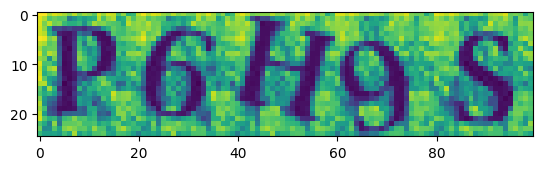

label : P6H9S


In [89]:

_ = random.choice(range(x_train.shape[0]))
plt.imshow(x_train[_].transpose(1, 2, 0)*255)
plt.show()

label = ""
for char in y_train[_].argmax(-1):
    label+=alphabets[char]
print(f"label : {label}")

In [90]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(911, 1, 25, 100)
(911, 5, 62)
(89, 1, 25, 100)
(89, 5, 62)


**MODEL**

In [ ]:
class CAptcha_CNN(nn.Module):
    def __init__(self,input_dim,hidden_dim_1,hidden_dim_2,hidden_dim_3, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_dim, hidden_dim_1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3),
            nn.Conv2d(hidden_dim_1, hidden_dim_2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.3),
            nn.Conv2d(hidden_dim_2, hidden_dim_3, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(hidden_dim_3 * 3 * 12, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            
        )

        self.softmax_layers = nn.ModuleList([nn.Linear(512, 62) for _ in range(output_dim)])

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        outs = []
        for layer in self.softmax_layers:
            outs.append(F.softmax(layer(x),dim=-1))

        return torch.stack(outs, dim=1)

In [92]:
model = CAptcha_CNN(1, 32, 48, 64, NUM_OF_LETTERS)
print(model(torch.rand(10,1, 25, 100)).shape)
print(sum(p.numel() for p in model.parameters()))

torch.Size([10, 5, 62])
1455334


In [ ]:
tensor_x = torch.Tensor(x_train) # transform to torch tensor 
tensor_y = torch.Tensor(y_train) 

my_dataset = TensorDataset(tensor_x,tensor_y) # training
my_dataloader = DataLoader(my_dataset,batch_size=BATCH_SIZE) 


tensor_x_t = torch.Tensor(x_test) # transform to torch tensor 
tensor_y_t = torch.Tensor(y_test) 

my_dataset_t = TensorDataset(tensor_x_t,tensor_y_t) 
my_dataloader_t = DataLoader(my_dataset_t,batch_size=BATCH_SIZE) #test

In [94]:
def loss_fn(y_pred, y_true):
    y_pred = torch.clip(y_pred, 1e-5, 1-1e-5)
    l = -y_true*torch.log(y_pred)
    l = l.sum(-1).sum(-1)
    return l.mean() 
optimizer = optim.Adam(model.parameters(), lr=LR)

**Training**

In [95]:
model.to(device)
for epoch in range(EPOCHS):
    model.train()
    train_L = 0
    for batch_idx, (batch_data, batch_targets) in enumerate(my_dataloader):
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)
        outputs = model(batch_data)

        loss = loss_fn(outputs, batch_targets)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_L+=loss.item()
        # for p in model.parameters():
        #     print(p.grad)
    
    model.eval()
    with torch.no_grad():
        # correct = 0
        count=0
        for batch_data, batch_targets in my_dataloader_t:
            batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device)
            outputs = model(batch_data)

            batch_targets=batch_targets.argmax(dim=-1)
            outputs=outputs.argmax(dim=-1)
            correct = (outputs == batch_targets)#.sum().item()
            
            for i in correct.sum(dim=-1):
                if i.item()==5:
                    count+=1
        print(count,len(my_dataset_t))
        accuracy = 100 * count / (len(my_dataset_t))
        print(f"\nTest Accuracy: {accuracy}%")

        # Print batch progress
        
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {train_L/len(my_dataset)}")


0 89

Test Accuracy: 0.0%
Epoch [1/150], Loss: 3.074062485595435
0 89

Test Accuracy: 0.0%
Epoch [2/150], Loss: 3.04159230170475
0 89

Test Accuracy: 0.0%
Epoch [3/150], Loss: 3.0373697877584513
0 89

Test Accuracy: 0.0%
Epoch [4/150], Loss: 3.0361185712427
0 89

Test Accuracy: 0.0%
Epoch [5/150], Loss: 3.035432851144433
0 89

Test Accuracy: 0.0%
Epoch [6/150], Loss: 3.0336630032954965
0 89

Test Accuracy: 0.0%
Epoch [7/150], Loss: 3.033529945314912
0 89

Test Accuracy: 0.0%
Epoch [8/150], Loss: 3.033656014569112
0 89

Test Accuracy: 0.0%
Epoch [9/150], Loss: 3.0327389337097905
0 89

Test Accuracy: 0.0%
Epoch [10/150], Loss: 3.033076452764015
0 89

Test Accuracy: 0.0%
Epoch [11/150], Loss: 3.0322447985116265
0 89

Test Accuracy: 0.0%
Epoch [12/150], Loss: 3.0322862911957156
0 89

Test Accuracy: 0.0%
Epoch [13/150], Loss: 3.031707051818379
0 89

Test Accuracy: 0.0%
Epoch [14/150], Loss: 3.031203574589919
0 89

Test Accuracy: 0.0%
Epoch [15/150], Loss: 3.0319070700887267
0 89

Test Accur

Test Accuracy: 98.87640449438203%

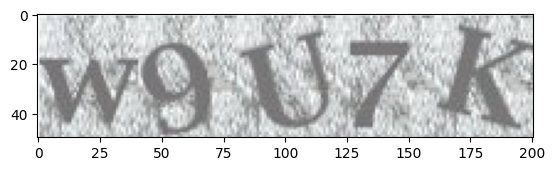

NameError: name 'model' is not defined

In [7]:
import os
import cv2
import matplotlib.pyplot as plt
_ = random.choice(range(1000, 1999))
path=f'/home/datascience/Desktop/Capt/ss2/{_}.png'
img=cv2.imread(path)
# img = plt.imread(path)
# cv2.rectangle(img,(578,468),(781,521),(255,25,1),2)
plt.imshow(img, cmap='gray')
# plt.title('Example Image')
img_new=img[471:521,580:781]
plt.imshow(img_new,cmap='gray')
plt.show()
img = cv2.cvtColor(img_new, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (int(201/2), int(50/2)), interpolation=cv2.INTER_AREA)
img = np.reshape(img, (img.shape[0], img.shape[1], 1))
img=np.expand_dims(np.transpose(img, axes=( 2,0,1)),axis=0)
# img.shape
a=model(torch.tensor(img,dtype=torch.float).to(device)/255)[0]
# print(a)
a=np.array(a.cpu().detach())
al="0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
# for i in a[0][0]:
# print(a[0].shape,np.where(a[0][0]==1))
# print(a)
for i in range(5):
  # print(a[i],np.where(a[i]==1.)[0][0])
  # print(a[i])
  print(al[np.array(a[i]).argmax()],end="")

In [108]:
a

array([[0.0114669 , 0.01144643, 0.01139151, 0.01147286, 0.01141259,
        0.01143597, 0.01150487, 0.01140164, 0.01152762, 0.01146996,
        0.01311965, 0.01969894, 0.01843662, 0.015557  , 0.01697717,
        0.02098325, 0.01872126, 0.01202295, 0.01066536, 0.01005883,
        0.01722374, 0.01137201, 0.00623795, 0.0099059 , 0.01153478,
        0.01378326, 0.01785693, 0.00960353, 0.00511898, 0.0103607 ,
        0.00863912, 0.01326008, 0.0150517 , 0.01079197, 0.01264964,
        0.01164616, 0.01536838, 0.00693948, 0.01697791, 0.01237729,
        0.01529422, 0.00613872, 0.01854892, 0.01019061, 0.01141939,
        0.02064314, 0.0087361 , 0.007186  , 0.00820685, 0.01291736,
        0.01141299, 0.00677475, 0.01194558, 0.00881238, 0.2504538 ,
        0.01054722, 0.01021441, 0.01136678, 0.00731839, 0.02268032,
        0.01029606, 0.01142512],
       [0.01033999, 0.01026681, 0.37294206, 0.00838459, 0.02330945,
        0.00882745, 0.00752945, 0.00868689, 0.00634686, 0.00939807,
        0.01025

In [143]:
bb=[0.00000e+00, 0.00000e+00, 0.00000e+00 ,0.00000e+00 ,0.00000e+00, 0.00000e+00,
 0.00000e+00, 0.00000e+00 ,0.00000e+00, 0.00000e+00 ,0.00000e+00 ,0.00000e+00,
 0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00, 0.00000e+00,
 0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00,
 0.00000e+00 ,1.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00,
 0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00,
 0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00,
 0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00,
 0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,0.00000e+00,
 0.00000e+00, 0.00000e+00 ,0.00000e+00 ,0.00000e+00 ,1.72573e-40 ,0.00000e+00,
 0.00000e+00 ,0.00000e+00]


In [145]:
np.array(bb).max()

1.0

Save the MODEL

In [110]:
torch.save(model.state_dict(), "/home/datascience/Desktop/Capt/model/model_smooth.pth")

Load and inference

In [8]:
NUM_OF_LETTERS=5
model_load =CAptcha_CNN(1, 32, 48, 64, NUM_OF_LETTERS)

model_load.load_state_dict(torch.load( "/home/datascience/Desktop/Capt/model/model_smooth.pth"))

<All keys matched successfully>

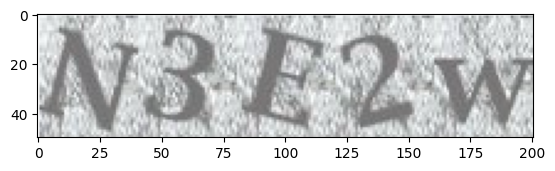

N3E2w

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_load.to(device)
_ = random.choice(range(1000, 1999))
path=f'/home/datascience/Desktop/Capt/ss2/{_}.png'
img=cv2.imread(path)
# img = plt.imread(path)
# cv2.rectangle(img,(578,468),(781,521),(255,25,1),2)
plt.imshow(img, cmap='gray')
# plt.title('Example Image')
img_new=img[471:521,580:781]
plt.imshow(img_new,cmap='gray')
plt.show()
img = cv2.cvtColor(img_new, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (int(201/2), int(50/2)), interpolation=cv2.INTER_AREA)
img = np.reshape(img, (img.shape[0], img.shape[1], 1))
img=np.expand_dims(np.transpose(img, axes=( 2,0,1)),axis=0)
# img.shape
a=model_load(torch.tensor(img,dtype=torch.float).to(device)/255)[0]
# print(a)
a=np.array(a.cpu().detach())
al="0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
# for i in a[0][0]:
# print(a[0].shape,np.where(a[0][0]==1))
# print(a)
for i in range(5):
  # print(a[i],np.where(a[i]==1.)[0][0])
  # print(a[i])
  print(al[np.array(a[i]).argmax()],end="")

In [1]:
import torch
torch.__version__

'1.10.1+cu111'

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

DATA COLLECTION VIA SELENIUM

In [13]:
!pip install selenium

  Using cached selenium-4.9.0-py3-none-any.whl (6.5 MB)
  Using cached trio_websocket-0.10.2-py3-none-any.whl (17 kB)
  Using cached trio-0.22.0-py3-none-any.whl (384 kB)
  Using cached sniffio-1.3.0-py3-none-any.whl (10 kB)
  Using cached async_generator-1.10-py3-none-any.whl (18 kB)
  Using cached exceptiongroup-1.1.1-py3-none-any.whl (14 kB)
  Using cached outcome-1.2.0-py2.py3-none-any.whl (9.7 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached wsproto-1.2.0-py3-none-any.whl (24 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)
  Using cached h11-0.14.0-py3-none-any.whl (58 kB)


In [14]:
from selenium import webdriver
from selenium.webdriver.common.by import By 
from selenium.webdriver import FirefoxOptions

In [ ]:
def driver():
    opts = FirefoxOptions()
    opts.add_argument('--no-sandbox')
    opts.add_argument("--headless")
    opts.add_argument("--incognito")
    opts.add_argument("--disable-notifications")
    # opts.set_preference('prefs', profile)
    # opts.add_argument('--kiosk-printing')
    binary='/firefox-106.0.3/firefox/firefox'
    path="/gecko32/geckodriver"
    profile = webdriver.FirefoxProfile()
    profile.set_preference("browser.cache.disk.enable", False)
    profile.set_preference("browser.cache.memory.enable", False)
    profile.set_preference("browser.cache.offline.enable", False)
    profile.set_preference("network.http.use-cache", False) 
    wd = webdriver.Firefox(firefox_binary=binary,options=opts,firefox_profile=profile)
    original_size = wd.get_window_size()
    return wd, original_size
wd,original_size=driver()

/tmp/ipykernel_24133/4118816024.py:12: DeprecationWarning: firefox_profile has been deprecated, please use an Options object
  profile = webdriver.FirefoxProfile()
/tmp/ipykernel_24133/4118816024.py:17: DeprecationWarning: firefox_binary has been deprecated, please pass in a Service object
  wd = webdriver.Firefox(firefox_binary=binary,options=opts,firefox_profile=profile)
/tmp/ipykernel_24133/4118816024.py:17: DeprecationWarning: firefox_profile has been deprecated, please pass in an Options object
  wd = webdriver.Firefox(firefox_binary=binary,options=opts,firefox_profile=profile)


In [16]:
wd.get("https://www.sedar.com/GetFile.do?lang=EN&docClass=5&issuerNo=00027103&issuerType=03&projectNo=03513310&docId=5388440")
wd.delete_all_cookies()
required_width = wd.execute_script('return document.body.parentNode.scrollWidth')
required_height = wd.execute_script('return document.body.parentNode.scrollHeight')
wd.set_window_size(required_width, required_height)
wd.find_element(By.TAG_NAME,'body').screenshot("DevTry.png")
wd.set_window_size(original_size['width'], original_size['height'])
print("checked screenshot code")


checked screenshot code
